In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
from tabulate import tabulate
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
columns = ["age", "yredu", "capgain", "caploss", "workhr"]
table = []

for col in columns:
    ave = np.average(df[col])
    min = np.min(df[col])
    max = np.max(df[col])
    table.append( [col, ave, min, max] )
    
    # normalize between 0 and 1
    df[col] = (df[col] - min) / (max-min)

print( tabulate(table, headers=['column', 'average', 'min', 'max']) )

subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records


column      average    min    max
--------  ---------  -----  -----
age         38.5816     17     90
yredu       10.0807      1     16
capgain   1077.65        0  99999
caploss     87.3038      0   4356
workhr      40.4375      1     99


,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
table = []
sexes = [' Male', ' Female']

for s in sexes:
    table.append( [s, 100*np.sum(df["sex"] == s) / len(df.index) ] )

print( tabulate(table, headers=['sex', 'Percentage']) )

sex       Percentage
------  ------------
Male         66.9205
Female       33.0795


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print(f"{len(df_with_missing.index)} records contained missing features.")
print(f"{100 * len(df_with_missing.index)/ len(df.index)}% of records were removed.")

1843 records contained missing features.
5.660145572924664% of records were removed.


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
workTypes = set( df_not_missing['work'] )
print(workTypes)

{' Federal-gov', ' Local-gov', ' Self-emp-not-inc', ' Without-pay', ' Self-emp-inc', ' Private', ' State-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print( f"The dataframe contains {len(data.columns)} columns." )

The dataframe contains 57 columns.


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_onehot(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    return cat_values[feature][np.argmax(onehot)]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# Randomly shuffle the data
np.random.seed(50)
np.random.shuffle( datanp )

# Get starting indexes of training, validation, and testing sets
train_start = 0
valid_start = int( len(datanp) * 0.7 )
test_start = int( len(datanp) * 0.85 )

# Splice the original dataset
trainSet = datanp[train_start:valid_start]
validSet = datanp[valid_start:test_start]
testSet = datanp[test_start:]

print( tabulate([['Train', len(trainSet)],
                 ['Valid', len(validSet)],
                 ['Test', len(testSet)]],
                headers=['Set', 'Length']))

# create dataloaders
batchSize = 64
train = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, num_workers=1)
valid = torch.utils.data.DataLoader(validSet, batch_size=batchSize, num_workers=1)
test = torch.utils.data.DataLoader(testSet, batch_size=batchSize, num_workers=1)

Set      Length
-----  --------
Train     21502
Valid      4608
Test       4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder dimensions
        dim1 = 57
        dim2 = 40
        dim3 = 20

        self.encoder = nn.Sequential(
            nn.Linear(dim1, dim2),
            nn.Linear(dim2, dim3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim3, dim2),
            nn.Linear(dim2, dim1),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)



---
Since the values in datanp are normalized between the values of 0 and 1 before they were encoded, sigmoid activation will bring the final values back between 0 and 1. This is to represent the normalized data in the dataframe.


## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train_model(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    trainRecord = [[],[]] # [0] for loss [1] for accuracy
    validRecord = [] # only accuracy

    for epoch in range(num_epochs):

        print(f"[Epoch: {epoch}]")

        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # keep track of loss and accuracy
            trainRecord[0].append(loss)
            trainRecord[1].append( get_accuracy(model, train_loader) )
            validRecord.append( get_accuracy(model, valid_loader) )

            print(f"ACC: {trainRecord[1][-1]} | LOSS: {trainRecord[0][-1]}")
        
    plot(trainRecord, validRecord)


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

def plot(trainReport, validReport):
    """
    Use matlibplot to make accuracy and loss plots for training and test sets.
    Print out final loss and accuracies.

    Inputs:
    ------
    trainReport: (array of arrays) array[0]=loss data, array[1]=acc data
    validReport: (array) valid acc
    """
    xAxis = np.arange(1, len(trainReport[0]) + 1).tolist()

    # Loss
    plt.title("Loss")
    plt.plot(xAxis, trainReport[0], label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Acc
    plt.title("Accuracy")
    plt.plot(xAxis, trainReport[1], label="Training")
    plt.plot(xAxis, validReport, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

    print("-----------------FINAL LOSS-----------------")
    print(f"Training        :   {trainReport[0][-1]}")

    print("-----------------FINAL  ACC-----------------")
    print(f"Training        :   {trainReport[1][-1]}")
    print(f"Validation      :   {validReport[-1]}")

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [ ]:
model = AutoEncoder()
epochs = 3
lr = 1e-3
train_model(model, train, valid, num_epochs=epochs, learning_rate=lr)

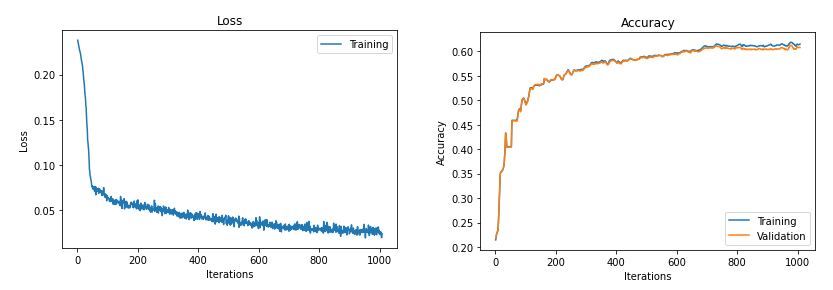

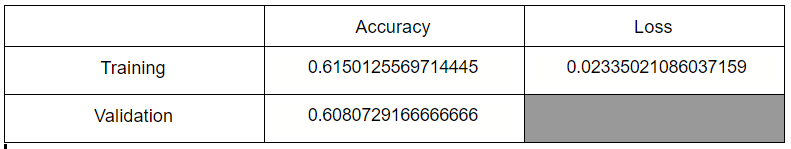

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Learning Rates

In [ ]:
lrs = [1e-3, 7e-4, 5e-4, 3e-4]
model = AutoEncoder()
epochs = 3

for lr in lrs:
    print(f"- - - - LEARNING RATE : {lr} - - - -")
    train_model(model, train, valid, num_epochs=epochs, learning_rate=lr)


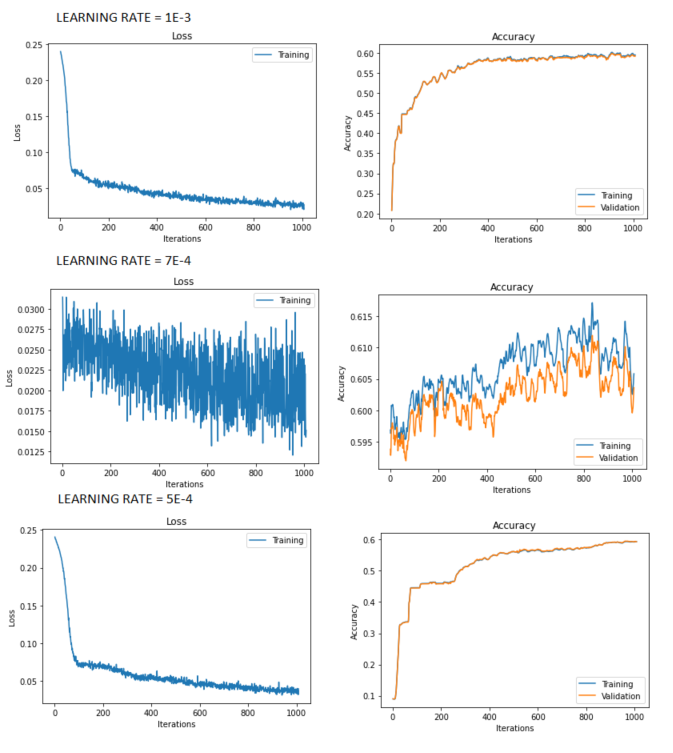

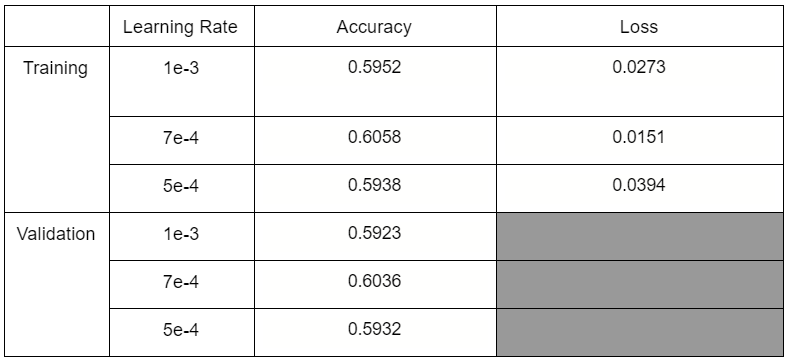

Testing batchsize

In [ ]:
# create dataloaders
batchSizes = [128, 32]
epochs = 3
lr = 5e-4


for bs in batchSizes:
    train = torch.utils.data.DataLoader(trainSet, batch_size=bs, num_workers=1)
    valid = torch.utils.data.DataLoader(validSet, batch_size=bs, num_workers=1)
    test = torch.utils.data.DataLoader(testSet, batch_size=bs, num_workers=1)

    model = AutoEncoder()

    print(f"- - - - BATCH SIZE : {bs} - - - -")
    train_model(model, train, valid, num_epochs=epochs, learning_rate=lr)

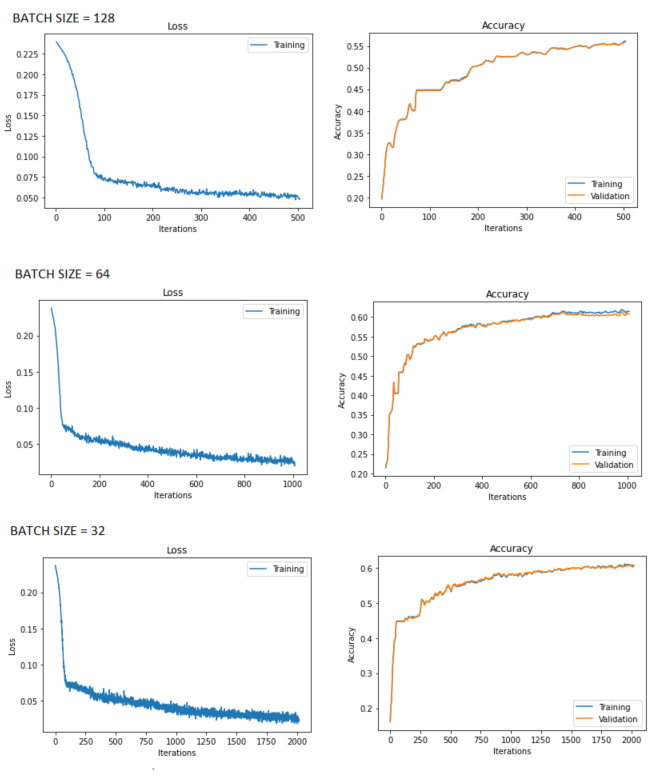

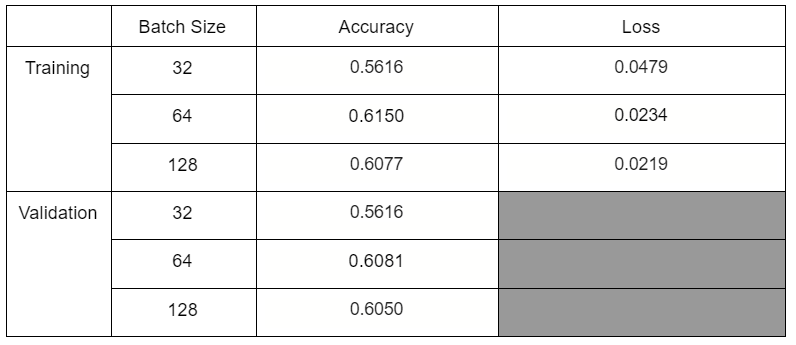

Number of Parameters

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder dimensions
        dim1 = 57
        dim2 = 30
        dim3 = 10

        self.encoder = nn.Sequential(
            nn.Linear(dim1, dim2),
            nn.Linear(dim2, dim3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim3, dim2),
            nn.Linear(dim2, dim1),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# create dataloaders
batchSize = 64
epochs = 3
lr = 5e-4
model = AutoEncoder()
train_model(model, train, valid, num_epochs=epochs, learning_rate=lr)

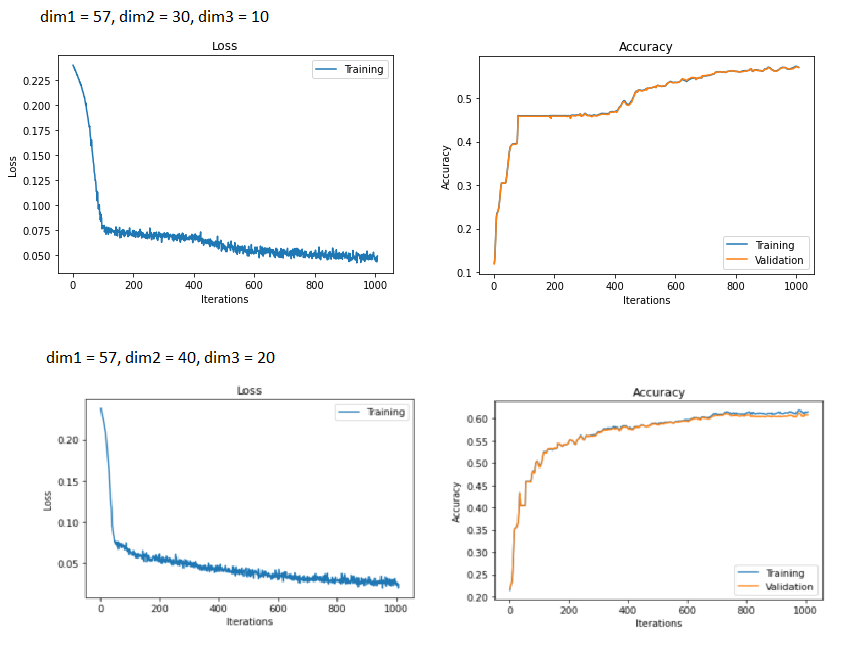

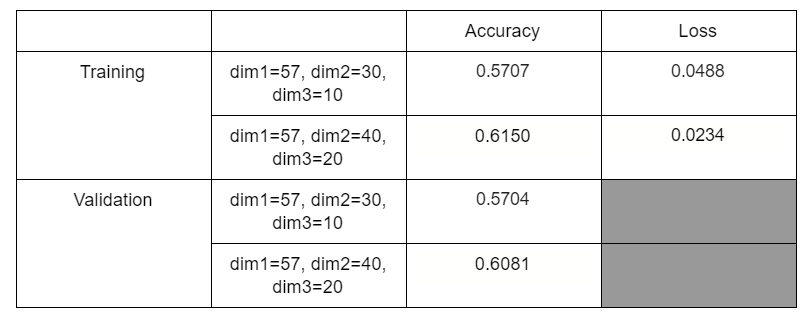



> Learning rate: 7e-4

> Batch size: 64

> NN parameters: dim1=57, dim2=40, dim3=20

First, I started by choosing the learning rate. Varying from 1e-3, 7e-4, and 5e-4, I chose the learning rate that had the highest validation accuracy.

Taking my best learning rate, I then experimented with batch sizes of 32, 64, and 128. The results were all quite stable, and I chose to use 64 as it had the highest validation accuracy.

Lastly, I chose the number of parameters, also by choosing the architecture that would maximize validation accuracy.

